# Compare CSIRO above ground biomass plots with AusEFlux

Or, compare with Fluxcom-RS which has a spatial resolution of ~8km.  Fluxcom data is only for NEE.

All data and outputs and code are on google drive

## Import packages

In [1]:
import os
import sys
import folium
import odc.geo.xr
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

## Analysis Parameters

Variables to adjust depending on analysis required

In [2]:
var = 'NEE' # 'NEE', 'ER', or 'GPP'
suffix = 'v1.1' #version of AusEFlux
product = 'AusEFlux' # 'AusEFlux' or 'Fluxcom'

# date range to extract from AusEflux (or fluxcom)
start_date = '2003-01'
end_date = '2021-12' #fluxcom stops at 2015

#locations of files
auseflux_flux_loc = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions/AusEFlux_'+var+'_2003_2022_1km_quantiles_'+suffix+'.nc'
fluxcom_flux_loc = '/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/NEE_rs.nc'
input_loc = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'
output_loc = '/g/data/os22/chad_tmp/climate-carbon-interactions/results/csiro_plots/'

## Import data

### Import gridded flux data

In [3]:
if product == 'AusEFlux':
    ds = assign_crs(xr.open_dataset(auseflux_flux_loc), crs='epsg:4326')[var+'_median']
    print(ds)

if product =='Fluxcom':
    ds = assign_crs(xr.open_dataset(fluxcom_flux_loc), crs='epsg:4326')[var]
    print(ds)

<xarray.DataArray 'NEE_median' (time: 234, latitude: 3400, longitude: 4200)>
[3341520000 values with dtype=float32]
Coordinates:
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2003-01-15 2003-02-15 ... 2022-06-15
  * latitude     (latitude) float32 -10.01 -10.02 -10.02 ... -43.99 -43.99
  * longitude    (longitude) float32 112.0 112.0 112.0 ... 154.0 154.0 154.0
Attributes:
    grid_mapping:  spatial_ref


## Import CSIRO plots

And convert to geopandas to allow for exploring interactively on a map

In [4]:
#open as pandas dataframe
sites = pd.read_csv(input_loc+'CSIRO_plot_locations.csv')

#convert to geodataframe
gdf_sites = gpd.GeoDataFrame(
    sites, geometry=gpd.points_from_xy(sites.Long, sites.Lat), crs="EPSG:4326"
)

## Exploratory Interactive plots

Uncomment if interested

In [5]:
#plot the site data over a basemap

# gdf_sites.explore(column='Plot number',
#                   attr='Esri',
#                  tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}')

In [6]:
#plot the first timestep of AusEFlux on a basemap

# # # Create folium Map (ipyleaflet is also supported)
# m = folium.Map(control_scale = True)

# # Plot each sample image with different colormap
# ds.isel(time=0).odc.add_to(m, cmap='RdBu_r', robust=True)


# # Zoom map to Australia
# m.fit_bounds(ds.isel(time=0).odc.map_bounds())

# tile = folium.TileLayer(
#         tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#         attr = 'Esri',
#         name = 'Esri Satellite',
#         overlay = True,
#         control = True
#        ).add_to(m)

# folium.LayerControl().add_to(m)
# display(m)

## Extract pixel values over plot sites

Two sites: `'Olive Creek'` and `'Downfall'` are adjacent permnanent waterbodies, and are thus masked out in AusEflux.

In [7]:
td = []
for i in range(0, len(sites)):
    # indexing spatiotemporal values at CSIRO sites
    idx=dict(latitude=sites.iloc[i]['Lat'],
             longitude=sites.iloc[i]['Long'])

    # grab nearest pixel
    da = ds.sel(idx, method='nearest').sel(time=slice(start_date, end_date)) 
    
    # convert to dataframe and rename
    da = da.rename(var).to_dataframe().drop(['longitude', 'latitude', 'spatial_ref'], axis=1)
    
    #convert fluxcom to /month instead of /day
    if product == 'Fluxcom':
        da[var] = da[var]*30
    
    # add site id
    da['plot_number'] = sites.iloc[i]['Plot number']
    da['plot_name'] = sites.iloc[i]['Plot name']
    td.append(da)

# 'dropna' will remove the two sites beside water
ts = pd.concat(td)
ts.head()

,NEE,plot_number,plot_name
time,,,
2003-01-15,-16.778891,EP18,Mount Lewis
2003-02-15,-12.194727,EP18,Mount Lewis
2003-03-15,-26.488781,EP18,Mount Lewis
2003-04-15,-28.833372,EP18,Mount Lewis
2003-05-15,-38.542725,EP18,Mount Lewis


## Save full timeseries to csv

In [8]:
ts.to_csv(output_loc+var+'_'+product+'_CSIRO_plots.csv')

## Generate some plots

### Box plots of annual mean flux

In [9]:
df_annual_mean = ts[[var, 'plot_number']].groupby('plot_number').resample('Y').mean()

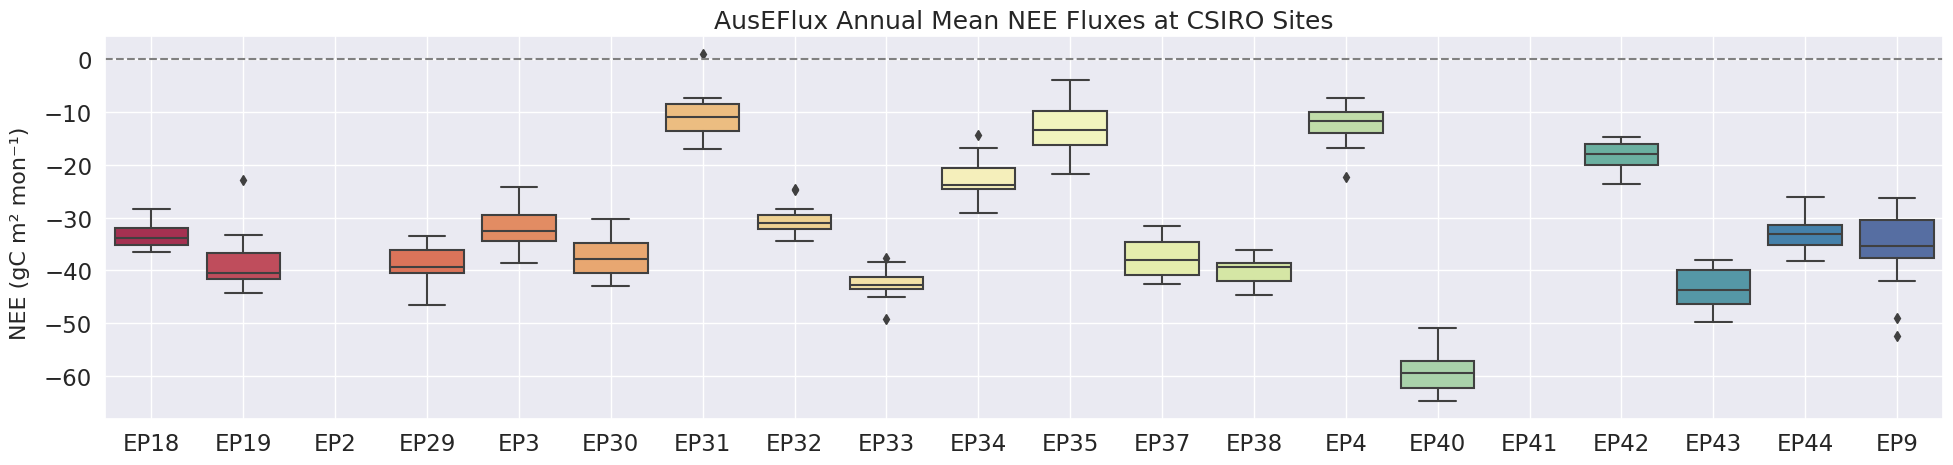

In [10]:
sb.set(font_scale=1.5)

fig, ax =  plt.subplots(1,1,figsize=(20,5), sharex=True)
sb.boxplot(x='plot_number',
           y=var,
           data=df_annual_mean.reset_index(),
           ax=ax,palette='Spectral')
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines
ax.set_ylabel('')
ax.set_xlabel('')
if var == 'NEE':
    ax.axhline(0, c='grey', linestyle='--')
fig.supylabel(var+' (gC m\N{SUPERSCRIPT TWO} mon⁻¹)', fontsize=16);
plt.title(product+' Annual Mean '+var+' Fluxes at CSIRO Sites')
plt.tight_layout()

fig.savefig(output_loc+product+'_annual_mean_boxplot_'+var+'.png',
            bbox_inches='tight', dpi=300)

### Annual Cumulative NEE flux boxplots

If plotting NEE. 

To convert to total flux (rather than flux per m2), we need to multiply the fluxes by the area of the pixel size (in AusEflux this is ~1km or ~5km depending on the dataset, and for Fluxcom-RS this is ~8km) used. To do this, we need to reproject the geobox to albers equal area.

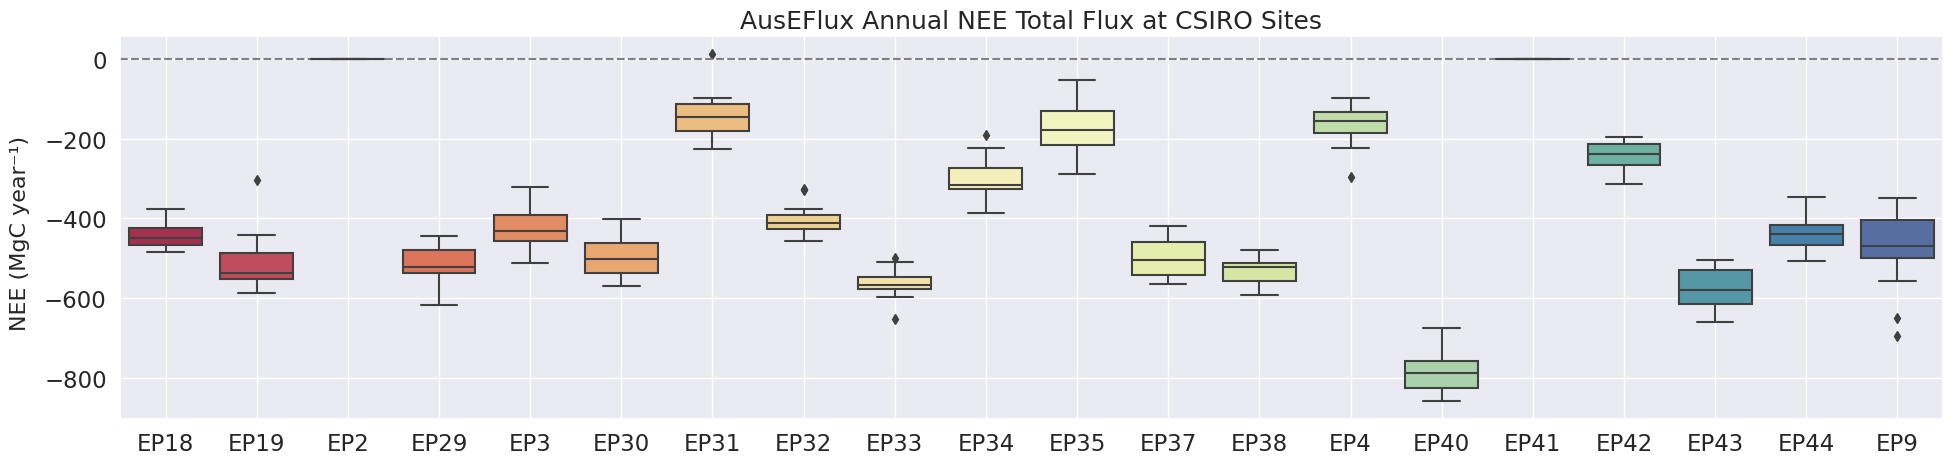

In [11]:
if var=='NEE':
    #find area of pixel in m2 - first convert to equal area grid
    grid = ds.odc.geobox.to_crs('EPSG:3577')
    area_per_pixel = grid.resolution.x**2

    #find annual sums
    df_annual_sum = ts[[var, 'plot_number']].groupby('plot_number').resample('Y').sum().drop('plot_number',axis=1)

    #Convert to total annual flux in Megagrams of Carbon
    df_annual_sum = df_annual_sum * area_per_pixel * 1e-6

    #plot
    fig, ax =  plt.subplots(1,1,figsize=(20,5), sharex=True)
    sb.boxplot(x='plot_number',
               y=var,
               data=df_annual_sum.reset_index(),
               ax=ax,palette='Spectral')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True) 
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.axhline(0, c='grey', linestyle='--')
    fig.supylabel(var+' (MgC year⁻¹)', fontsize=16);
    plt.title(product+' Annual '+var+' Total Flux at CSIRO Sites')
    plt.tight_layout()
    fig.savefig(output_loc+product+'_annual_sum_boxplot_'+var+'.png',
                bbox_inches='tight', dpi=300)

## Tropical Eddy Covariance Flux Towers

Extract from TERN THREDDS and summarise

FletchersView is only a year old so its commented out

### Open EC data

In [12]:
robson_creek_loc = 'https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/RobsonCreek/2022_v2/L6/default/RobsonCreek_L6_20130801_20220816_Monthly.nc'
cape_tribulation_loc = 'https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/CapeTribulation/2022_v2/L6/default/CapeTribulation_L6_20100101_20181102_Monthly.nc'
cowbay_loc = 'https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/CowBay/2022_v2/L6/default/CowBay_L6_20090101_20220816_Monthly.nc'
# fletcher = 'https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/Fletcherview/2022_v2/L6/default/FletcherviewTropicalRangeland_L6_20220122_20220712_Monthly.nc'

#open sites
robson_creek = xr.open_dataset(robson_creek_loc)[var+'_SOLO']
cape_tribulation = xr.open_dataset(cape_tribulation_loc)[var+'_SOLO']
cowbay = xr.open_dataset(cowbay_loc)[var+'_SOLO']


### Process EC sites into annual means

Be sure to only calculate annual means in years with all data

In [13]:
arrs = []
for df, name in zip([robson_creek, cape_tribulation, cowbay], ['RobsCreek', 'CapeTrib', 'Cowbay']):
    #find years with 12 months of data
    years_with_all_months = (df.groupby('time.year').count()==12).values
    df = df.resample(time='Y').mean()
    df = df.where(years_with_all_months)
    df = df.to_dataframe()
    df['plot_name'] = name
    df = df.dropna()
    arrs.append(df)

df = pd.concat(arrs)

### Plot annual mean fluxes at EC towers 

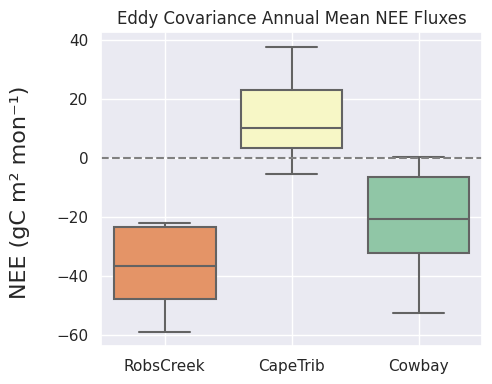

In [14]:
sb.set(font_scale=1)

fig, ax =  plt.subplots(1,1,figsize=(5,4), sharex=True)
sb.boxplot(x='plot_name',
           y=var+'_SOLO',
           data=df,
           ax=ax,
           palette='Spectral')
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('')
ax.set_xlabel('')
if var == 'NEE':
    ax.axhline(0, c='grey', linestyle='--')
fig.supylabel(var+' (gC m\N{SUPERSCRIPT TWO} mon⁻¹)', fontsize=16);
plt.title('Eddy Covariance Annual Mean '+var+' Fluxes')
plt.tight_layout()
fig.savefig(output_loc+'EC_annual_mean_boxplot_'+var+'.png',
            bbox_inches='tight', dpi=300)